In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Get the base model

In [3]:
from keras.models import load_model

In [4]:
model_path = "./cats_and_dogs_small_2.h5"
model = load_model(model_path)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

# Lets us analyse the model - only the CNN part

In [27]:
model.input_shape

(None, 150, 150, 3)

In [30]:
layer_names = []

for i, layer in enumerate(model.layers[:8]):
    
    print(layer.input_shape)
    print(layer.output_shape)
    layer_names.append(layer.name)
    print("\n")
    
print(layer_names)

(None, 150, 150, 3)
(None, 148, 148, 32)


(None, 148, 148, 32)
(None, 74, 74, 32)


(None, 74, 74, 32)
(None, 72, 72, 64)


(None, 72, 72, 64)
(None, 36, 36, 64)


(None, 36, 36, 64)
(None, 34, 34, 128)


(None, 34, 34, 128)
(None, 17, 17, 128)


(None, 17, 17, 128)
(None, 15, 15, 128)


(None, 15, 15, 128)
(None, 7, 7, 128)


['conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3', 'conv2d_4', 'max_pooling2d_4']


# Prepare the image to be processed/deciphered

In [11]:
from keras.preprocessing import image
import numpy as np

In [14]:
image_path = 'D:/Datasets/cats_and_dogs_small/test/cats/1577.jpg'

In [15]:
img = image.load_img(image_path, target_size=(150,150))
print(type(img))

img_tensor = image.img_to_array(img)
print(type(img_tensor))
print(img_tensor.shape)

(150, 150, 3)

In [16]:
img_tensor = np.expand_dims(img_tensor, axis=0) # add 4th dim for batch size
print(img_tensor.shape)
img_tensor = img_tensor /255.0

(1, 150, 150, 3)

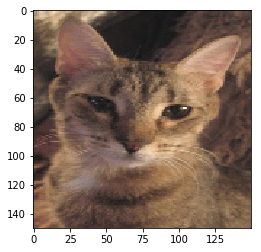

In [20]:
from matplotlib import pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

# Get the pipeline to extract output of layers

In [33]:
from keras.models import Model

In [34]:
layer_outputs = [layer.output for layer in model.layers[:8]]

In [35]:
for o in layer_output:
    print(o.shape)

(?, 148, 148, 32)
(?, 74, 74, 32)
(?, 72, 72, 64)
(?, 36, 36, 64)
(?, 34, 34, 128)
(?, 17, 17, 128)
(?, 15, 15, 128)
(?, 7, 7, 128)


In [36]:
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [37]:
activations = activation_model.predict(img_tensor)

# Decipher the output of activation_model

In [46]:
# let us understand a output

print(activations[0].shape)

sample_filter_output = activations[0][0, :, :, 14]
print(sample_filter_output.shape)
print(type(sample_filter_output))

(1, 148, 148, 32)
(148, 148)
<class 'numpy.ndarray'>


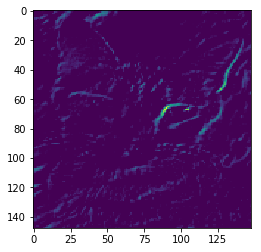

In [48]:
from matplotlib import pyplot as plt



plt.imshow(sample_filter_output)
plt.show()

c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


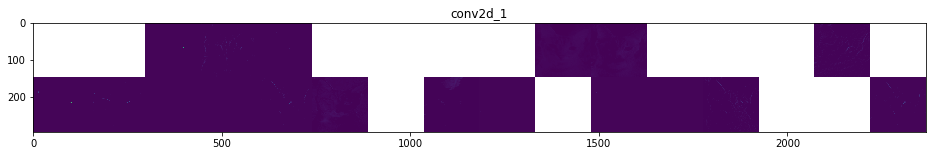

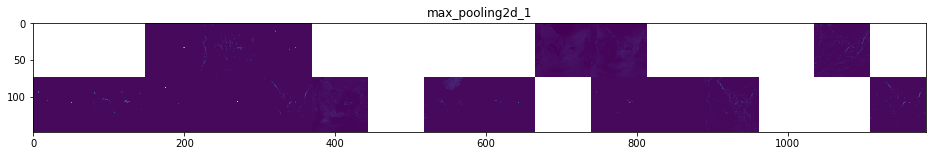

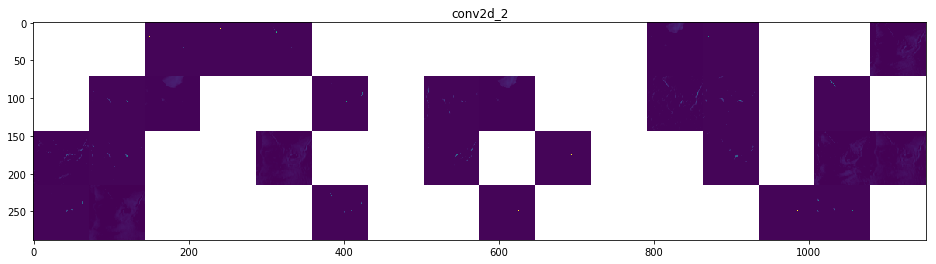

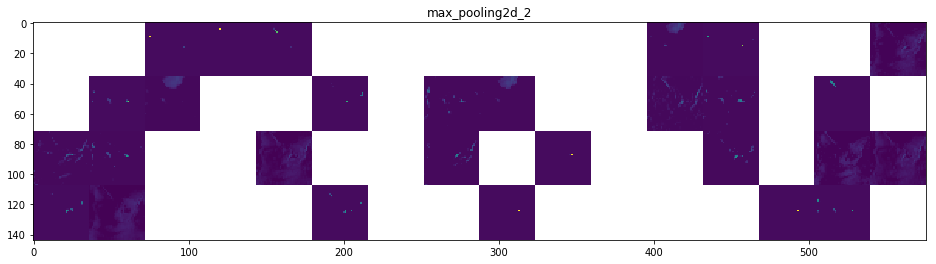

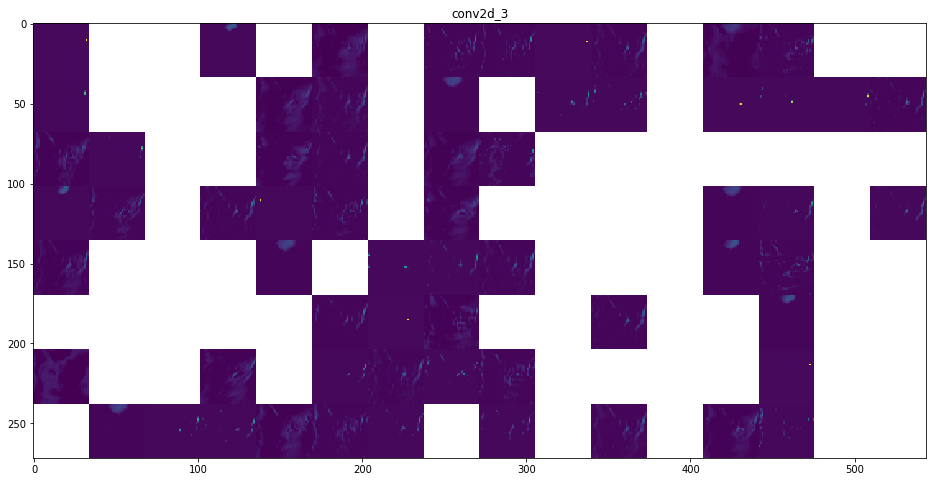

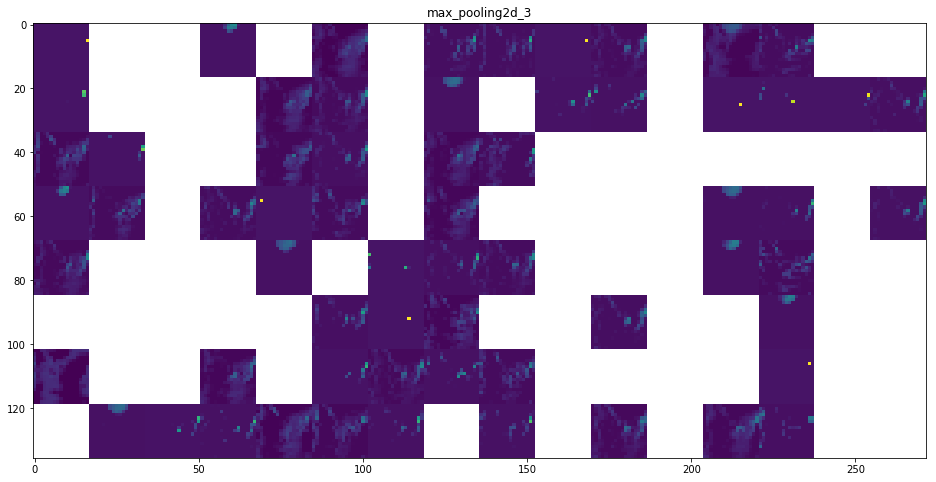

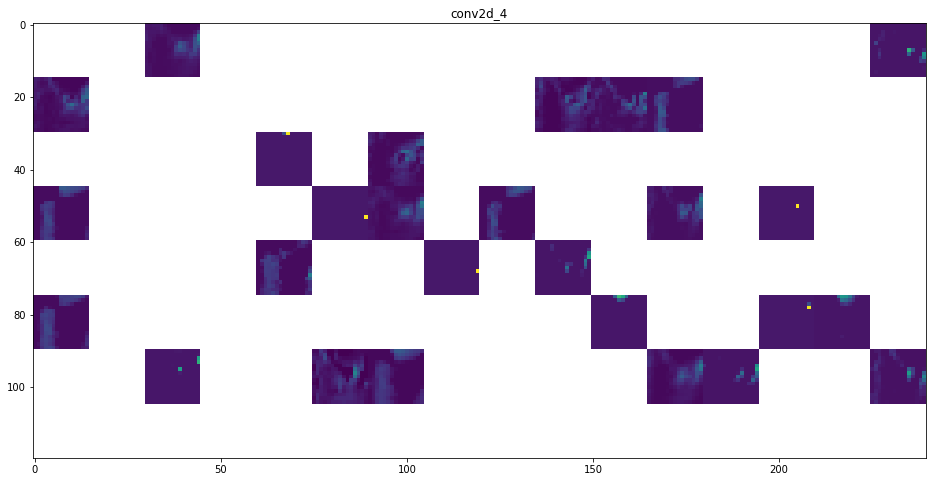

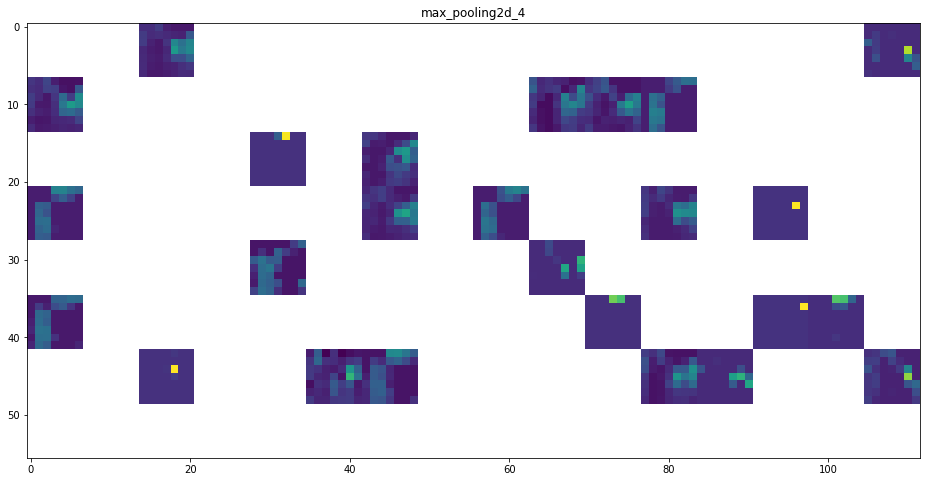

In [66]:
# let us plot this systematically

images_per_row = 16

for layer_name, activation in zip(layer_names, activations):
    
    num_of_filters = activation.shape[-1]
    
    height_width = activation.shape[1]  
    
    num_of_rows = num_of_filters // images_per_row
    
    layout_grid = np.zeros(shape=(num_of_rows * height_width, images_per_row * height_width))
    
    #fill the grid
    for row in range(num_of_rows):
        for col in range(images_per_row):
            
            channel_image = activation[0,:,:, images_per_row *row+col]
            
            #normalize the image
            channel_image = channel_image - channel_image.mean()
            channel_image = channel_image / channel_image.std()
            
            channel_image *= 64
            channel_image += 128            
            
            
            layout_grid[row*height_width:(row+1)*height_width, col*height_width:(col+1)*height_width] = channel_image
            
    scale = 1. / height_width
    plt.figure(figsize=(scale * layout_grid.shape[1], scale * layout_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(layout_grid, aspect='auto', cmap='viridis')
    #plt.show()

c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


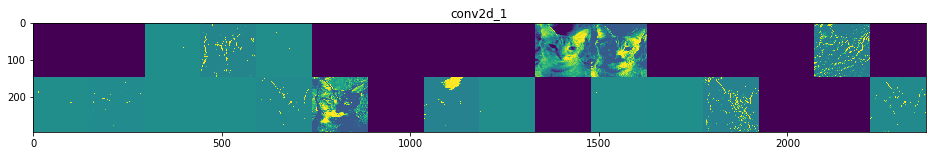

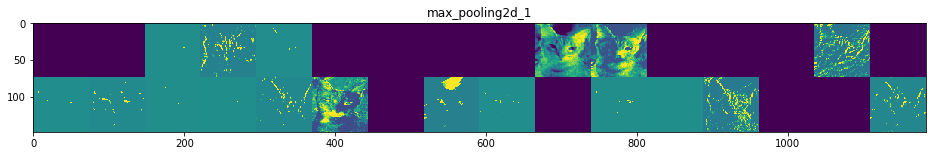

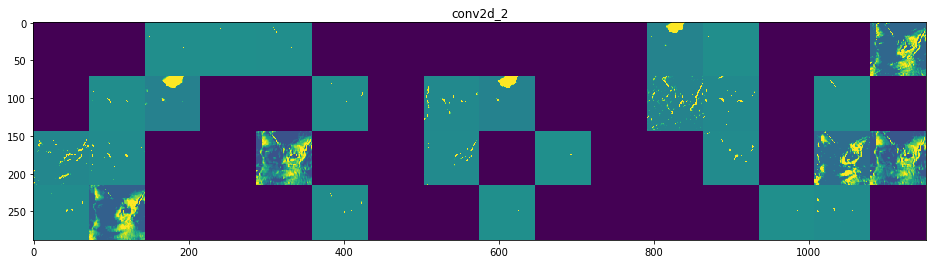

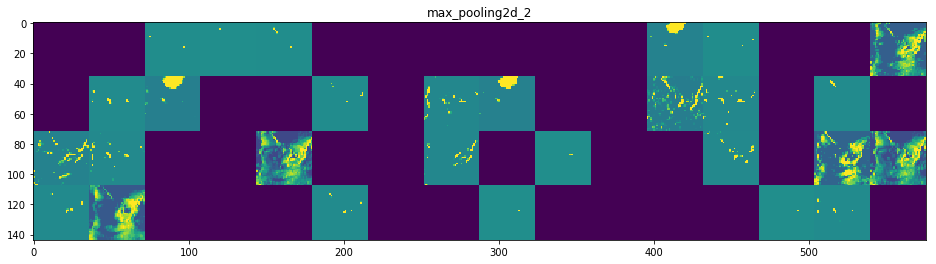

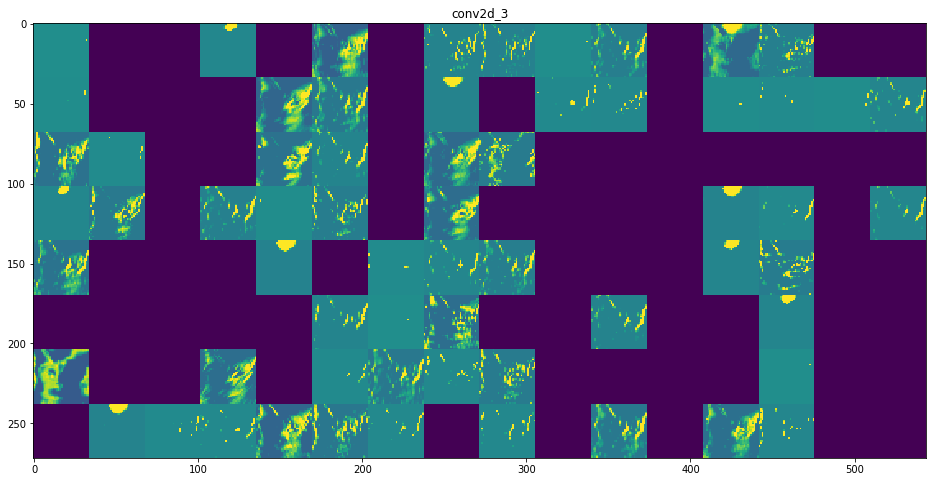

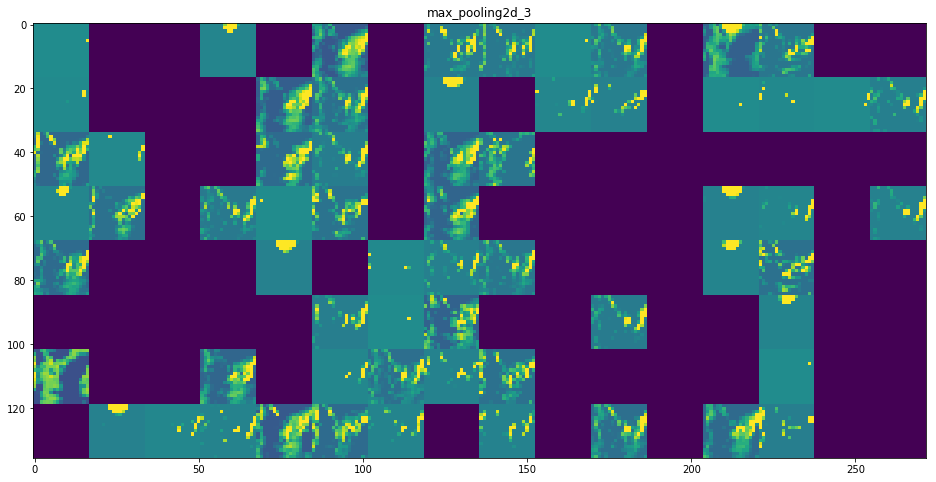

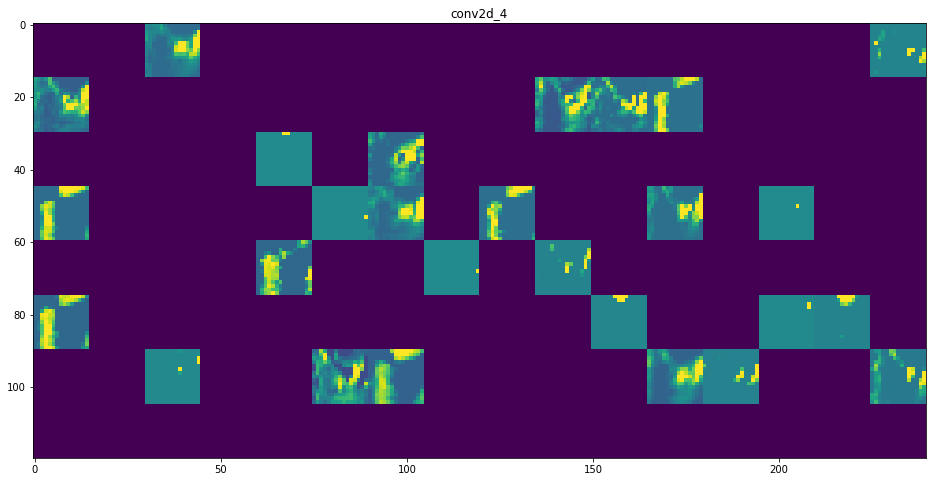

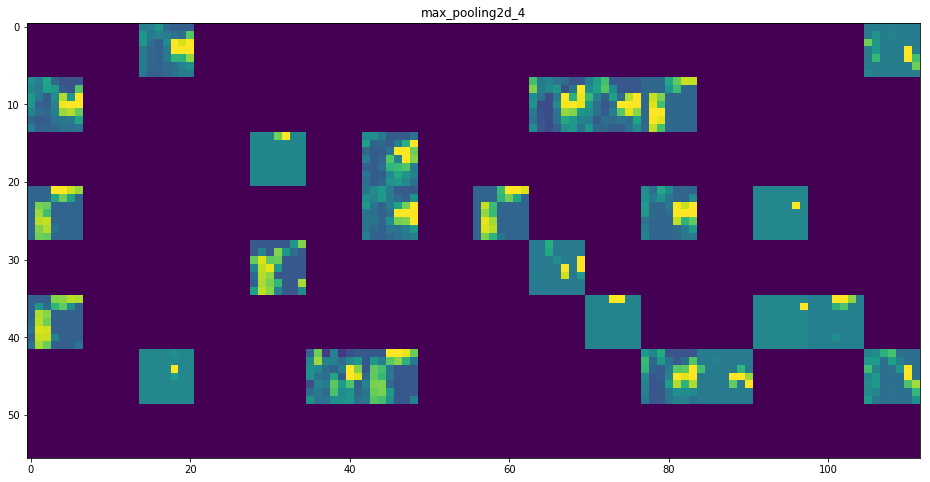

In [62]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    no_of_feature_maps = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_rows = no_of_feature_maps // images_per_row
    
    display_grid = np.zeros((size * n_rows, images_per_row * size))
    
    for row in range(n_rows):
        for col in range(images_per_row):
            channel_image = layer_activation[0,:,:,row*images_per_row+col]
            
            #normalize the image
            channel_image = channel_image - channel_image.mean()
            channel_image = channel_image / channel_image.std()
            
            channel_image *= 64
            channel_image += 128
            
            # this line is super crucial - it keeps all values as ints between 0, 255
            # this is the difference between previous cell and this one
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[row * size : (row + 1) * size, col * size : (col + 1) * size] = channel_image
            
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        